# Import Libraries

In [21]:
#Import Libraries

#for reading and data-manipulation
import os
import numpy as np
import pandas as pd




In [22]:
#for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis




In [23]:
#for data preprocessing
import time
from contractions import contractions_dict
import re
from collections import Counter
from wordcloud import STOPWORDS
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
# for ML model Implementation
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from bertopic import BERTopic
from sklearn.metrics import silhouette_score
import hdbscan
from sentence_transformers import SentenceTransformer
from umap import UMAP

# DATASET LOADING

In [25]:
df = pd.read_csv('Cell_Phone_Reviews/phone_user_review_file_1.csv', encoding='ISO-8859-1')
df.head()

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374910 entries, 0 to 374909
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   phone_url  374910 non-null  object 
 1   date       374910 non-null  object 
 2   lang       374910 non-null  object 
 3   country    374910 non-null  object 
 4   source     374910 non-null  object 
 5   domain     374910 non-null  object 
 6   score      366691 non-null  float64
 7   score_max  366691 non-null  float64
 8   extract    371934 non-null  object 
 9   author     371630 non-null  object 
 10  product    374910 non-null  object 
dtypes: float64(2), object(9)
memory usage: 31.5+ MB


In [27]:
df = df[df['product'].str.contains('Samsung', na=False)]
df = df[df['lang']=='en']

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64368 entries, 0 to 369253
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   phone_url  64368 non-null  object 
 1   date       64368 non-null  object 
 2   lang       64368 non-null  object 
 3   country    64368 non-null  object 
 4   source     64368 non-null  object 
 5   domain     64368 non-null  object 
 6   score      64359 non-null  float64
 7   score_max  64359 non-null  float64
 8   extract    64162 non-null  object 
 9   author     64331 non-null  object 
 10  product    64368 non-null  object 
dtypes: float64(2), object(9)
memory usage: 5.9+ MB


In [29]:
df = df[['phone_url', 'score', 'extract']].dropna()
df.rename(columns={'phone_url': 'unique_identifier', 'score': 'score', 'extract': 'brief_review'}, inplace=True)

In [30]:
df.head()

,unique_identifier,score,brief_review
0,/cellphones/samsung-galaxy-s8/,10.0,As a diehard Samsung fan who has had every Sam...
1,/cellphones/samsung-galaxy-s8/,10.0,Love the phone. the phone is sleek and smooth ...
2,/cellphones/samsung-galaxy-s8/,6.0,Adequate feel. Nice heft. Processor's still sl...
3,/cellphones/samsung-galaxy-s8/,9.2,Never disappointed. One of the reasons I've be...
4,/cellphones/samsung-galaxy-s8/,4.0,I've now found that i'm in a group of people t...


In [31]:
# for testing and computational reasons, I will be working with only 1000 datasets for now.
df = df.iloc[:11000]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11000 entries, 0 to 12383
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   unique_identifier  11000 non-null  object 
 1   score              11000 non-null  float64
 2   brief_review       11000 non-null  object 
dtypes: float64(1), object(2)
memory usage: 343.8+ KB


# Knowing your data 

In [32]:
df.describe()

,score
count,11000.000000
mean,8.971118
std,1.992207
min,1.000000
25%,8.800000
50%,10.000000
75%,10.000000
max,10.000000


In [33]:
# Handling missing values
df.isnull().sum()

unique_identifier    0
score                0
brief_review         0
dtype: int64

In [34]:
#handling duplicate values 
len(df[df.duplicated(subset=['brief_review'])])

93

In [35]:
len(df[df.duplicated(subset=['unique_identifier'])])


10996

In [36]:
df.score.value_counts()

score
10.0    6139
9.6     1219
9.2      779
8.0      722
2.0      541
8.8      450
8.4      337
6.0      208
4.0      171
7.6      135
7.2       73
6.8       52
6.4       39
5.2       28
5.6       21
4.4       18
4.8       15
3.6       14
9.0       13
2.8        8
3.2        7
9.3        4
1.0        3
8.3        1
3.0        1
2.4        1
7.0        1
Name: count, dtype: int64

In [37]:
# Drop duplicate 
df_cleaned = df.drop_duplicates(subset = ["brief_review", "unique_identifier"])
print(df_cleaned.head())

                unique_identifier  score  \
0  /cellphones/samsung-galaxy-s8/   10.0   
1  /cellphones/samsung-galaxy-s8/   10.0   
2  /cellphones/samsung-galaxy-s8/    6.0   
3  /cellphones/samsung-galaxy-s8/    9.2   
4  /cellphones/samsung-galaxy-s8/    4.0   

                                        brief_review  
0  As a diehard Samsung fan who has had every Sam...  
1  Love the phone. the phone is sleek and smooth ...  
2  Adequate feel. Nice heft. Processor's still sl...  
3  Never disappointed. One of the reasons I've be...  
4  I've now found that i'm in a group of people t...  


In [38]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10913 entries, 0 to 12383
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   unique_identifier  10913 non-null  object 
 1   score              10913 non-null  float64
 2   brief_review       10913 non-null  object 
dtypes: float64(1), object(2)
memory usage: 341.0+ KB


In [19]:
# #visualization for common words in entire documents
# # Chart - 4 visualization code

# # Combine all article content across categories
# combined_content = ' '.join(df_cleaned['brief_review'])

# #convert the whole content in lowercase
# combined_content = combined_content.lower()

# # Tokenize the combined content
# tokens = combined_content.split()

# # Filter out stopwords and non-alphanumeric words
# filtered_tokens = [word for word in tokens if word.isalpha() and word not in STOPWORDS]

# # Create a Counter to count word frequencies
# word_counter = Counter(filtered_tokens)

# # Choose the number of most common words to visualize
# num_common_words = 20
# common_words = word_counter.most_common(num_common_words)

# # Create a bar plot for common words
# plt.figure(figsize=(10, 6))
# plt.barh([word[0] for word in common_words], [count[1] for count in common_words], color='skyblue', edgecolor='black')
# plt.title('Common Words in Entire Documents')
# plt.xlabel('Word Frequency')
# plt.ylabel('Word')
# plt.tight_layout()

# # Display the plot
# plt.show()

NameError: name 'STOPWORDS' is not defined

# Textual Data Preprocessing

## 1. Expand Contraction

In [39]:
# Expand Contraction

# Function to expand contractions using the contractions_dict
def expand_contractions(text):
    # Regular expression pattern to match contractions
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        expanded = contractions_dict.get(match.lower())
        return expanded

    expanded_text = contractions_pattern.sub(expand_match, text)
    return expanded_text

# Apply the expand_contractions function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(expand_contractions)

## 2. Lower casing

In [40]:
#before lower casing
df_cleaned.brief_review[0]

'As a diehard Samsung fan who has had every Samsung phone since before the S series started, this has been my favorite upgrade so far. I am amazed at some of the reviews and think people may just have a defective device that needs to be replaced. The battery life is amazing.'

In [41]:
# Convert text in the "brief_review" column to lowercase
df_cleaned['brief_review'] = df_cleaned['brief_review'].str.lower()

In [42]:
#After lower casing
df_cleaned.brief_review[0]

'as a diehard samsung fan who has had every samsung phone since before the s series started, this has been my favorite upgrade so far. i am amazed at some of the reviews and think people may just have a defective device that needs to be replaced. the battery life is amazing.'

## 3. Removing Puncuations

In [43]:
# Remove Punctuations

# Function to remove punctuations from text
def remove_punctuations(text):
    # Create a translation table to remove punctuations
    translator = str.maketrans('', '', string.punctuation +'\n')

    # Apply the translation table to remove punctuations
    text_without_punctuations = text.translate(translator)
    return text_without_punctuations

# Apply the remove_punctuations function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(remove_punctuations)

In [44]:
#After removing punctuation
df_cleaned.brief_review[0]

'as a diehard samsung fan who has had every samsung phone since before the s series started this has been my favorite upgrade so far i am amazed at some of the reviews and think people may just have a defective device that needs to be replaced the battery life is amazing'

## 4. Removing URLs, and words that contain digits.

In [45]:
# Function to remove URLs from text
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return re.sub(url_pattern, '', text)

# Function to remove words containing digits from text
def remove_words_with_digits(text):
    return ' '.join(word for word in text.split() if not any(char.isdigit() for char in word))

# Apply the remove_urls function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(remove_urls)

# Apply the remove_words_with_digits function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(remove_words_with_digits)



## 5. Removing Stopwords, and White spaces 

In [46]:
 # Remove Stopwords
# Download the list of stopwords if not already downloaded
nltk.download('stopwords')

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Add unnecessary words to the list of English stopwords
stop_unnecessary_words = stop_words.union(set(['mr', 'people', 'would', 'year', 'said', 'say', 'also', 'wale', 'could']))


# Function to remove stopwords from text
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if len(word)>2]
    filtered_words = [word for word in words if word.lower() not in stop_unnecessary_words]
    return ' '.join(filtered_words)

# Apply the remove_stopwords function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/binitkc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
# Remove white spaces from the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].str.replace('\s+', ' ', regex=True)

<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
/var/folders/zl/sz8m1sq17kg0nb_7_b93gkn40000gn/T/ipykernel_74788/553858847.py:2: DeprecationWarning: invalid escape sequence \s
  df_cleaned['brief_review'] = df_cleaned['brief_review'].str.replace('\s+', ' ', regex=True)


## 6. Tokenization

In [48]:
# Tokenization

# Download the punkt package
nltk.download('punkt')
# Download the punkt_tab resource as well
nltk.download('punkt_tab')

# Function to tokenize text
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Apply the tokenize_text function to the "brief_review" column
df_cleaned['tokenized_content'] = df_cleaned['brief_review'].apply(tokenize_text)


[nltk_data] Downloading package punkt to /Users/binitkc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/binitkc/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [49]:
df_cleaned.head()

,unique_identifier,score,brief_review,tokenized_content
0,/cellphones/samsung-galaxy-s8/,10.0,diehard samsung fan every samsung phone since ...,"[diehard, samsung, fan, every, samsung, phone,..."
1,/cellphones/samsung-galaxy-s8/,10.0,love phone phone sleek smooth beautiful highly...,"[love, phone, phone, sleek, smooth, beautiful,..."
2,/cellphones/samsung-galaxy-s8/,6.0,adequate feel nice heft processors still slugg...,"[adequate, feel, nice, heft, processors, still..."
3,/cellphones/samsung-galaxy-s8/,9.2,never disappointed one reasons long samsung pr...,"[never, disappointed, one, reasons, long, sams..."
4,/cellphones/samsung-galaxy-s8/,4.0,found group carried phone pocket without probl...,"[found, group, carried, phone, pocket, without..."


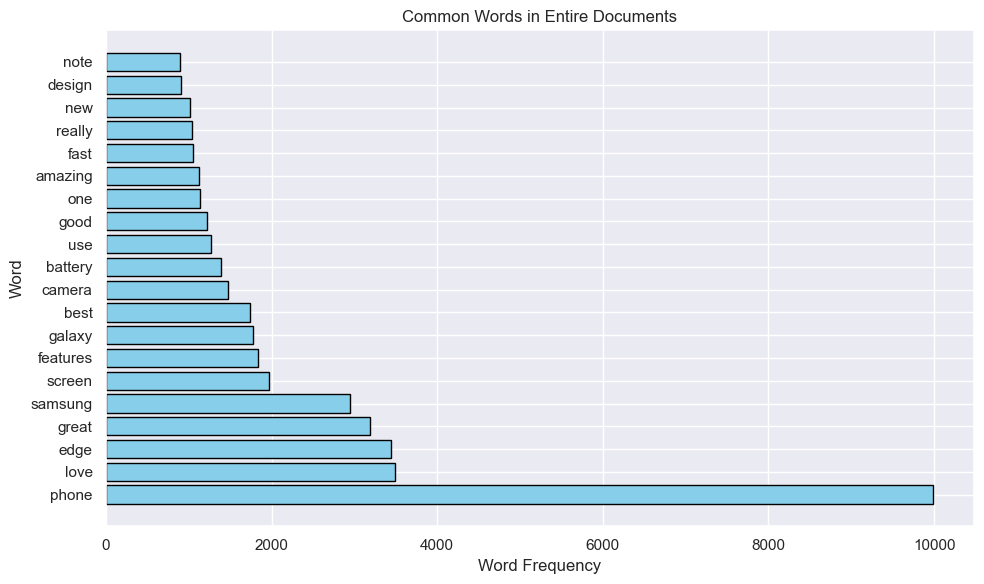

In [50]:
# Visualization after text preprocessing
#visualization for common words in entire documents
# Chart - 4 visualization code

# Combine all article content across categories
combined_content = ' '.join(df_cleaned['brief_review'])

#convert the whole content in lowercase
combined_content = combined_content.lower()

# Tokenize the combined content
tokens = combined_content.split()

# Filter out stopwords and non-alphanumeric words
filtered_tokens = [word for word in tokens if word.isalpha() and word not in STOPWORDS]

# Create a Counter to count word frequencies
word_counter = Counter(filtered_tokens)

# Choose the number of most common words to visualize
num_common_words = 20
common_words = word_counter.most_common(num_common_words)

# Create a bar plot for common words
plt.figure(figsize=(10, 6))
plt.barh([word[0] for word in common_words], [count[1] for count in common_words], color='skyblue', edgecolor='black')
plt.title('Common Words in Entire Documents')
plt.xlabel('Word Frequency')
plt.ylabel('Word')
plt.tight_layout()

# Display the plot
plt.show()

## 7. Text Normalization (Stemming, Lemmatization)

### 7.1 Stemming

In [51]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to perform stemming on text
def stem_text(tokens):
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

# Apply the stem_text function to the "tokenized_content" column
df_cleaned['stemmed_content'] = df_cleaned['tokenized_content'].apply(stem_text)

### 7.2 Lemmatization

In [52]:
nltk.download('wordnet')
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to perform lemmatization on text
def lemmatize_text(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

# Apply the lemmatize_text function to the "tokenized_content" column
df_cleaned['lemmatized_content'] = df_cleaned['tokenized_content'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /Users/binitkc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [53]:
df_cleaned.head()

,unique_identifier,score,brief_review,tokenized_content,stemmed_content,lemmatized_content
0,/cellphones/samsung-galaxy-s8/,10.0,diehard samsung fan every samsung phone since ...,"[diehard, samsung, fan, every, samsung, phone,...","[diehard, samsung, fan, everi, samsung, phone,...","[diehard, samsung, fan, every, samsung, phone,..."
1,/cellphones/samsung-galaxy-s8/,10.0,love phone phone sleek smooth beautiful highly...,"[love, phone, phone, sleek, smooth, beautiful,...","[love, phone, phone, sleek, smooth, beauti, hi...","[love, phone, phone, sleek, smooth, beautiful,..."
2,/cellphones/samsung-galaxy-s8/,6.0,adequate feel nice heft processors still slugg...,"[adequate, feel, nice, heft, processors, still...","[adequ, feel, nice, heft, processor, still, sl...","[adequate, feel, nice, heft, processor, still,..."
3,/cellphones/samsung-galaxy-s8/,9.2,never disappointed one reasons long samsung pr...,"[never, disappointed, one, reasons, long, sams...","[never, disappoint, one, reason, long, samsung...","[never, disappointed, one, reason, long, samsu..."
4,/cellphones/samsung-galaxy-s8/,4.0,found group carried phone pocket without probl...,"[found, group, carried, phone, pocket, without...","[found, group, carri, phone, pocket, without, ...","[found, group, carried, phone, pocket, without..."


In [54]:
df_cleaned.stemmed_content[0]

['diehard',
 'samsung',
 'fan',
 'everi',
 'samsung',
 'phone',
 'sinc',
 'seri',
 'start',
 'favorit',
 'upgrad',
 'far',
 'amaz',
 'review',
 'think',
 'may',
 'defect',
 'devic',
 'need',
 'replac',
 'batteri',
 'life',
 'amaz']

In [55]:
df_cleaned.lemmatized_content[0]


['diehard',
 'samsung',
 'fan',
 'every',
 'samsung',
 'phone',
 'since',
 'series',
 'started',
 'favorite',
 'upgrade',
 'far',
 'amazed',
 'review',
 'think',
 'may',
 'defective',
 'device',
 'need',
 'replaced',
 'battery',
 'life',
 'amazing']

In [56]:
# we can see that the lemmatized contents are better than the stemmed contents. 

## 8. POS Tagging

In [57]:
# # Download required NLTK packages
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')  # Ensure the punkt package is also downloaded

# # Function to perform POS tagging on text
# def pos_tagging(tokens):
#     pos_tags = pos_tag(tokens)
#     return pos_tags

# # Assuming df_cleaned['lemmatized_content'] contains tokenized text
# df_cleaned['pos_tags'] = df_cleaned['lemmatized_content'].apply(pos_tagging)


## 9. Text Vectorization

In [58]:

# Vectorizing Text

# Convert the list of lemmatized tokens into strings
lemmatized_text = [' '.join(tokens) for tokens in df_cleaned['lemmatized_content']]

# Initialize a CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the lemmatized text data
tfidf_matrix = vectorizer.fit_transform(lemmatized_text)

print('\n')
print('\n')
# Display the shape of the resulting matrix
print("Shape of the vectorized matrix:", tfidf_matrix.shape)
     





Shape of the vectorized matrix: (10913, 3775)


In [ ]:
# This tfidf_matrix can be used with scikit-learn based Topic modeling, but for now we will use gensim model so not used for now.

# ML model Implementation -LDA Model

In [60]:
# ML Model - 1 Implementation

# Convert the list of lemmatized tokens into a list of lists
lemmatized_text = [tokens for tokens in df_cleaned['lemmatized_content']]

# Create a dictionary of terms with term frequency filtering
dictionary = corpora.Dictionary(lemmatized_text)
dictionary.filter_extremes(no_below=3, no_above=0.85)

# Fit the Algorithm

# Create a Gensim corpus
corpus_gensim = [dictionary.doc2bow(text) for text in lemmatized_text]

# Build LDA model
num_topics = 5
lda_model = LdaModel(corpus_gensim, num_topics=num_topics, id2word=dictionary, passes=20, random_state= 40)

print('\n')
print('\n')
# Calculate coherence score
coherence_model = CoherenceModel(model=lda_model, texts=lemmatized_text, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

# Print coherence score
print(f"Coherence Score: {coherence_score:.4f}")


# Print topics and associated words
for topic_id, topic_words in lda_model.print_topics():
    print('\n')
    print(f"Topic {topic_id}: {topic_words}")

/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

Coherence Score: 0.4324


Topic 0: 0.058*"edge" + 0.031*"screen" + 0.029*"phone" + 0.021*"like" + 0.021*"love" + 0.019*"feature" + 0.016*"make" + 0.014*"water" + 0.011*"galaxy" + 0.010*"design"


Topic 1: 0.089*"phone" + 0.055*"samsung" + 0.036*"edge" + 0.036*"galaxy" + 0.035*"best" + 0.023*"love" + 0.021*"ever" + 0.019*"iphone" + 0.017*"one" + 0.017*"note"


Topic 2: 0.089*"phone" + 0.068*"great" + 0.042*"love" + 0.036*"camera" + 0.029*"feature" + 0.025*"fast" + 0.024*"battery" + 0.019*"easy" + 0.019*"amazing" + 0.019*"life"


Topic 3: 0.056*"phone" + 0.021*"battery" + 0.020*"day" + 0.017*"good" + 0.017*"work" + 0.016*"card" + 0.010*"month" + 0.010*"version" + 0.009*"got" + 0.009*"time"


Topic 4: 0.073*"phone" + 0.030*"screen" + 0.015*"great" + 0.014*"problem" + 0.014*"case" + 0.013*"get" + 0.012*"like" + 0.012*"week" + 0.012*"little" + 0.012*"work"


In [61]:
# import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import ParameterGrid
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel

# Define a grid of hyperparameters to search over
param_grid = {
    'num_topics': [3, 4, 5, 6, 7, 8, 9, 10],
    'passes': [10,15,20,25, 30]
}

best_coherence_score = -1
best_lda_model = None
scores = []  # To store coherence scores
topics = []  # To store number of topics
passes_list = []  # To store passes for each model

# Perform grid search
for params in ParameterGrid(param_grid):
    lda_model = LdaModel(corpus=corpus_gensim, id2word=dictionary, **params)
    coherence_model = CoherenceModel(model=lda_model, texts=lemmatized_text, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    # Track best model
    if coherence_score > best_coherence_score:
        best_coherence_score = coherence_score
        best_lda_model = lda_model
    
    # Collect data for plotting
    scores.append(coherence_score)
    topics.append(params['num_topics'])
    passes_list.append(params['passes'])


/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

In [69]:
# After grid search is completed and best_lda_model is chosen:
best_lda_model.save("Trained_models/lda_samsung.model")

# Optionally, print confirmation
print(" LDA_samsung model saved successfully!")

 LDA_samsung model saved successfully!


In [70]:
# Load the saved model
best_lda_model = LdaModel.load("Trained_models/lda_samsung.model")

# Optionally, print to confirm successful loading
print("LDA model loaded successfully!")

LDA model loaded successfully!


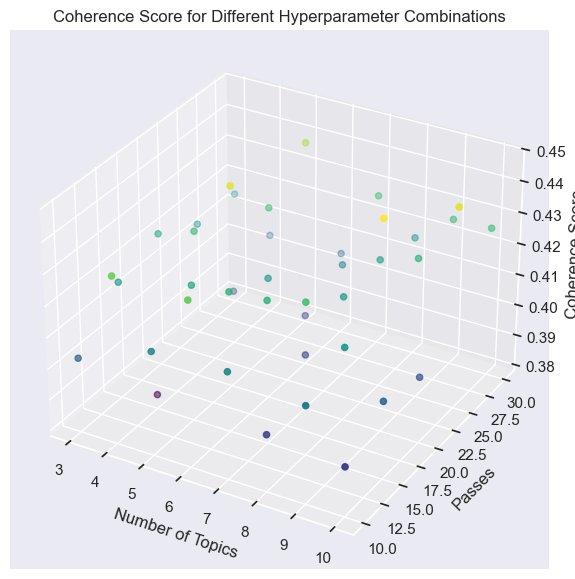

Best Hyperparameters: LdaModel<num_terms=2962, num_topics=9, decay=0.5, chunksize=2000>
Best Coherence Score: 0.4460

Topic 0: 0.101*"phone" + 0.035*"best" + 0.022*"one" + 0.021*"samsung" + 0.021*"ever" + 0.012*"can" + 0.012*"not" + 0.012*"far" + 0.010*"owned" + 0.010*"get"

Topic 1: 0.096*"battery" + 0.067*"phone" + 0.065*"life" + 0.048*"good" + 0.032*"day" + 0.024*"work" + 0.023*"last" + 0.021*"charge" + 0.018*"better" + 0.017*"great"

Topic 2: 0.053*"picture" + 0.048*"phone" + 0.040*"great" + 0.038*"take" + 0.034*"camera" + 0.033*"screen" + 0.030*"love" + 0.028*"really" + 0.023*"video" + 0.023*"color"

Topic 3: 0.065*"phone" + 0.064*"great" + 0.041*"camera" + 0.035*"fast" + 0.028*"feature" + 0.021*"design" + 0.020*"water" + 0.019*"amazing" + 0.019*"screen" + 0.016*"memory"

Topic 4: 0.096*"phone" + 0.056*"love" + 0.045*"edge" + 0.044*"feature" + 0.024*"use" + 0.019*"best" + 0.019*"easy" + 0.017*"great" + 0.017*"new" + 0.016*"everything"

Topic 5: 0.115*"screen" + 0.033*"case" + 0.02

In [71]:
# Plot coherence score in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(topics, passes_list, scores, c=scores, cmap='viridis', marker='o')
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Passes')
ax.set_zlabel('Coherence Score')
ax.set_title("Coherence Score for Different Hyperparameter Combinations")
plt.show()

# Print best hyperparameters and coherence score
print("Best Hyperparameters:", best_lda_model)
print(f"Best Coherence Score: {best_coherence_score:.4f}")

# Print topics and associated words for the best model
for topic_id, topic_words in best_lda_model.print_topics():
    print(f"\nTopic {topic_id}: {topic_words}")

In [78]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_topic_diversity(lda_model, num_topics):
    # Get the topic-word distributions from the LDA model
    topic_word_distributions = [lda_model.get_topics()[i] for i in range(num_topics)]
    
    # Calculate pairwise cosine similarities between topics
    similarities = cosine_similarity(topic_word_distributions)
    
    # Set diagonal elements to zero (similarity of a topic with itself should not be counted)
    np.fill_diagonal(similarities, 0)
    
    # Calculate topic diversity (1 - average cosine similarity)
    avg_similarity = np.mean(similarities)
    topic_diversity = 1 - avg_similarity
    
    return topic_diversity

# Assuming 'best_lda_model' is the trained model and 'num_topics' is the number of topics
topic_diversity = calculate_topic_diversity(best_lda_model, best_lda_model.num_topics)

print(f"Topic Diversity: {topic_diversity:.4f}")


Topic Diversity: 0.6972


In [72]:
lda_model = best_lda_model


In [73]:
# Visualize the topics
vis_data = gensimvis.prepare(lda_model, corpus_gensim, dictionary)
pyLDAvis.display(vis_data)

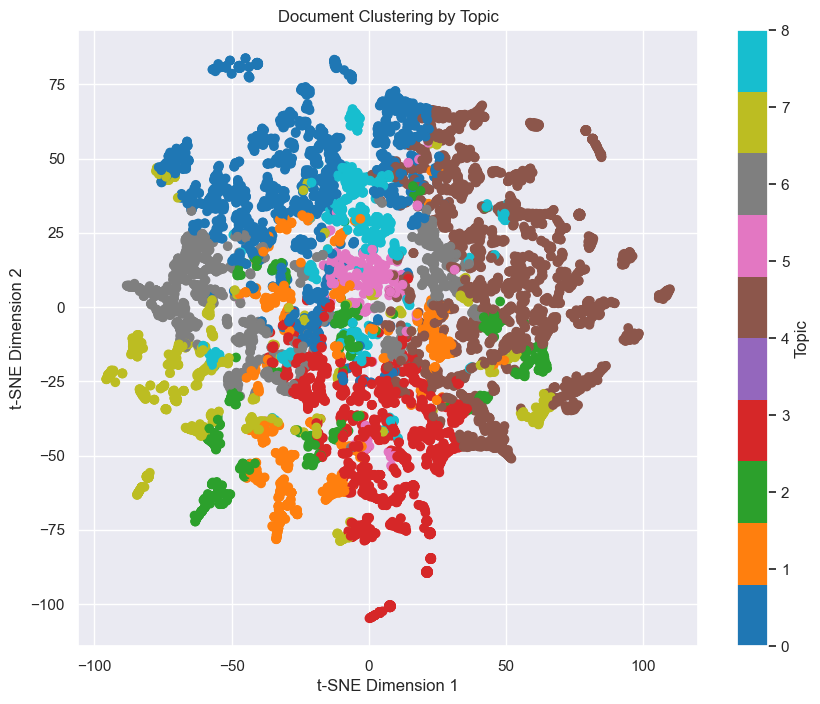

In [66]:
# # import numpy as np
# from sklearn.manifold import TSNE
# # import matplotlib.pyplot as plt

# # Generate the document-topic distribution for each document
# # Each element in `doc_topics` is a list of (topic_id, probability) tuples for a document
# doc_topics = [lda_model.get_document_topics(doc, minimum_probability=0) for doc in corpus_gensim]

# # Create the document-topic matrix where each row represents a document, and each column represents a topic's probability
# doc_topic_matrix = np.array([[topic[1] for topic in doc] for doc in doc_topics])

# # Apply t-SNE to document-topic matrix to reduce dimensions to 2
# tsne = TSNE(n_components=2, random_state=42)
# doc_topic_tsne = tsne.fit_transform(doc_topic_matrix)

# # Plot the t-SNE result
# plt.figure(figsize=(10, 8))
# plt.scatter(doc_topic_tsne[:, 0], doc_topic_tsne[:, 1], c=np.argmax(doc_topic_matrix, axis=1), cmap="tab10")
# plt.colorbar(label='Topic')
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
# plt.title("Document Clustering by Topic")
# plt.show()


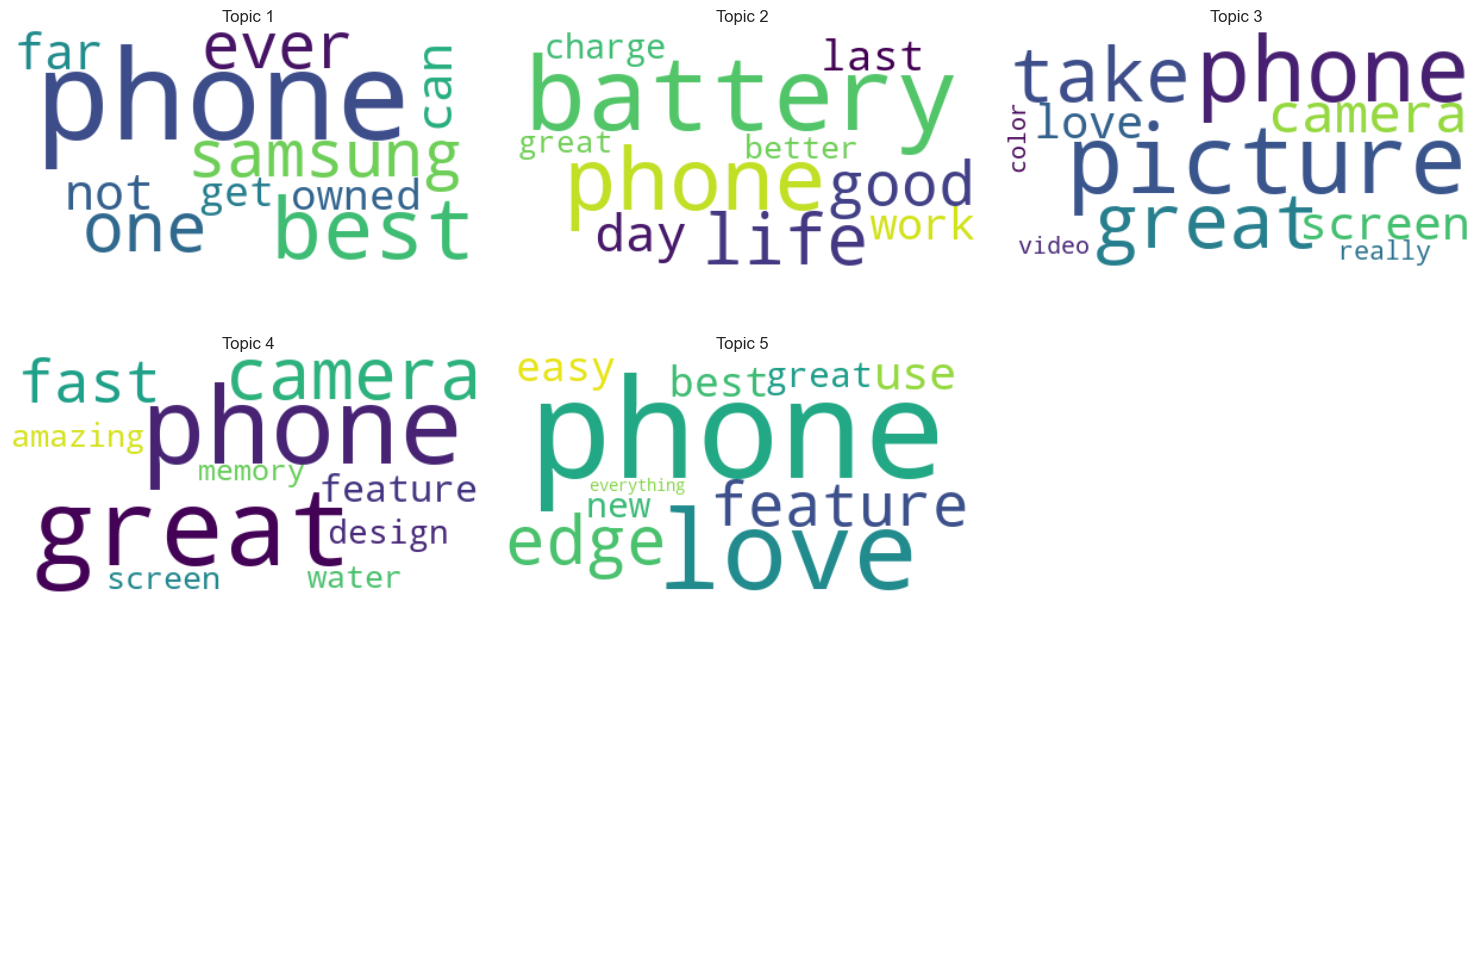

In [75]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# Function to plot word clouds for each topic
def plot_word_clouds(lda_model, num_topics, num_words=10, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()  # Flatten the 2D grid to iterate over

    for topic_id in range(num_topics):
        # Get the top words for the current topic
        words = dict(lda_model.show_topic(topic_id, topn=num_words))
        
        # Generate word cloud
        wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(words)
        
        # Plot word cloud in the subplot
        axes[topic_id].imshow(wordcloud, interpolation='bilinear')
        axes[topic_id].axis('off')
        axes[topic_id].set_title(f"Topic {topic_id + 1}")
    
    # Hide any remaining empty subplots
    for i in range(topic_id + 1, rows * cols):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot word clouds
plot_word_clouds(best_lda_model, num_topics)  


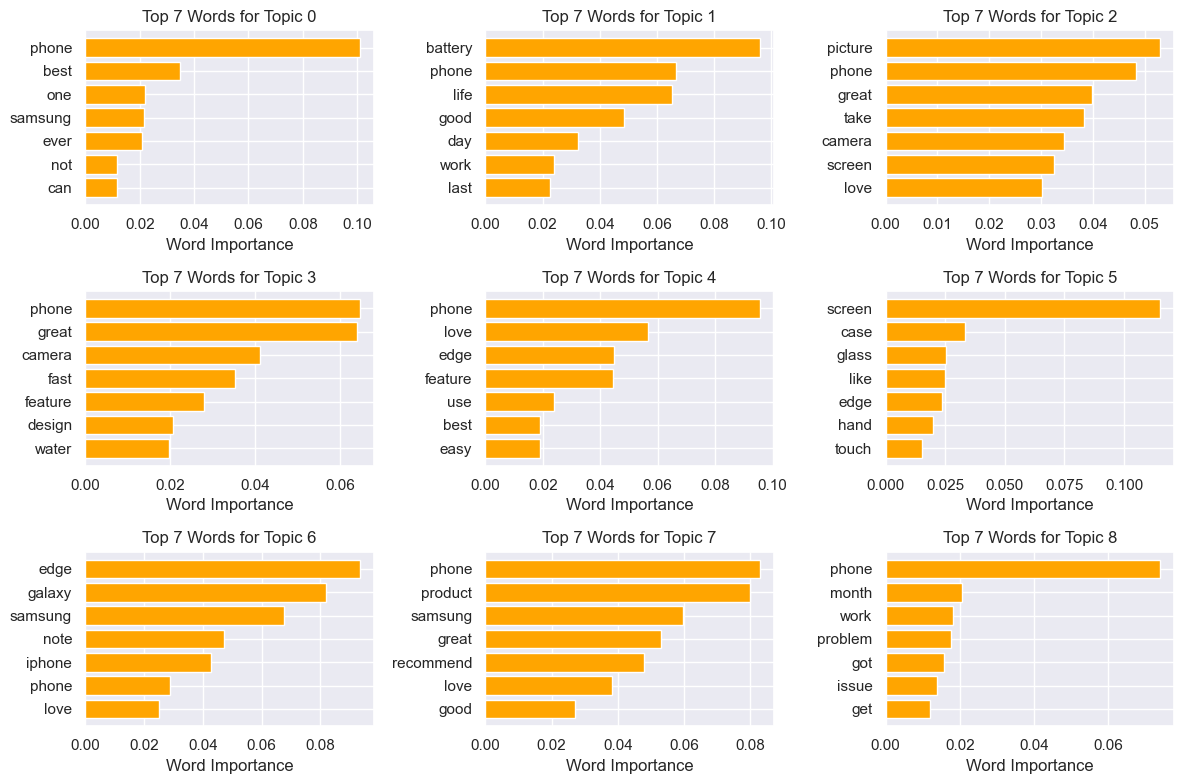

In [79]:
# import matplotlib.pyplot as plt

# Parameters
num_top_words = 7  # Number of top words to display for each topic
num_topics = lda_model.num_topics  # Total number of topics in the LDA model

# Define grid size for plotting (adjust based on the number of topics)
num_rows = 3
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Plot the top words for each topic
for topic_idx in range(num_topics):
    row = topic_idx // num_cols
    col = topic_idx % num_cols

    # Get the top words and weights for the current topic
    top_words = lda_model.show_topic(topic_idx, topn=num_top_words)
    words, weights = zip(*top_words)

    # Plot horizontal bar chart for the topic
    axes[row, col].barh(words, weights, color='orange')
    axes[row, col].set_title(f"Top {num_top_words} Words for Topic {topic_idx}")
    axes[row, col].set_xlabel("Word Importance")
    axes[row, col].invert_yaxis()  # Show the most important word at the top

# Remove empty subplots if the grid is larger than the number of topics
for i in range(num_topics, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


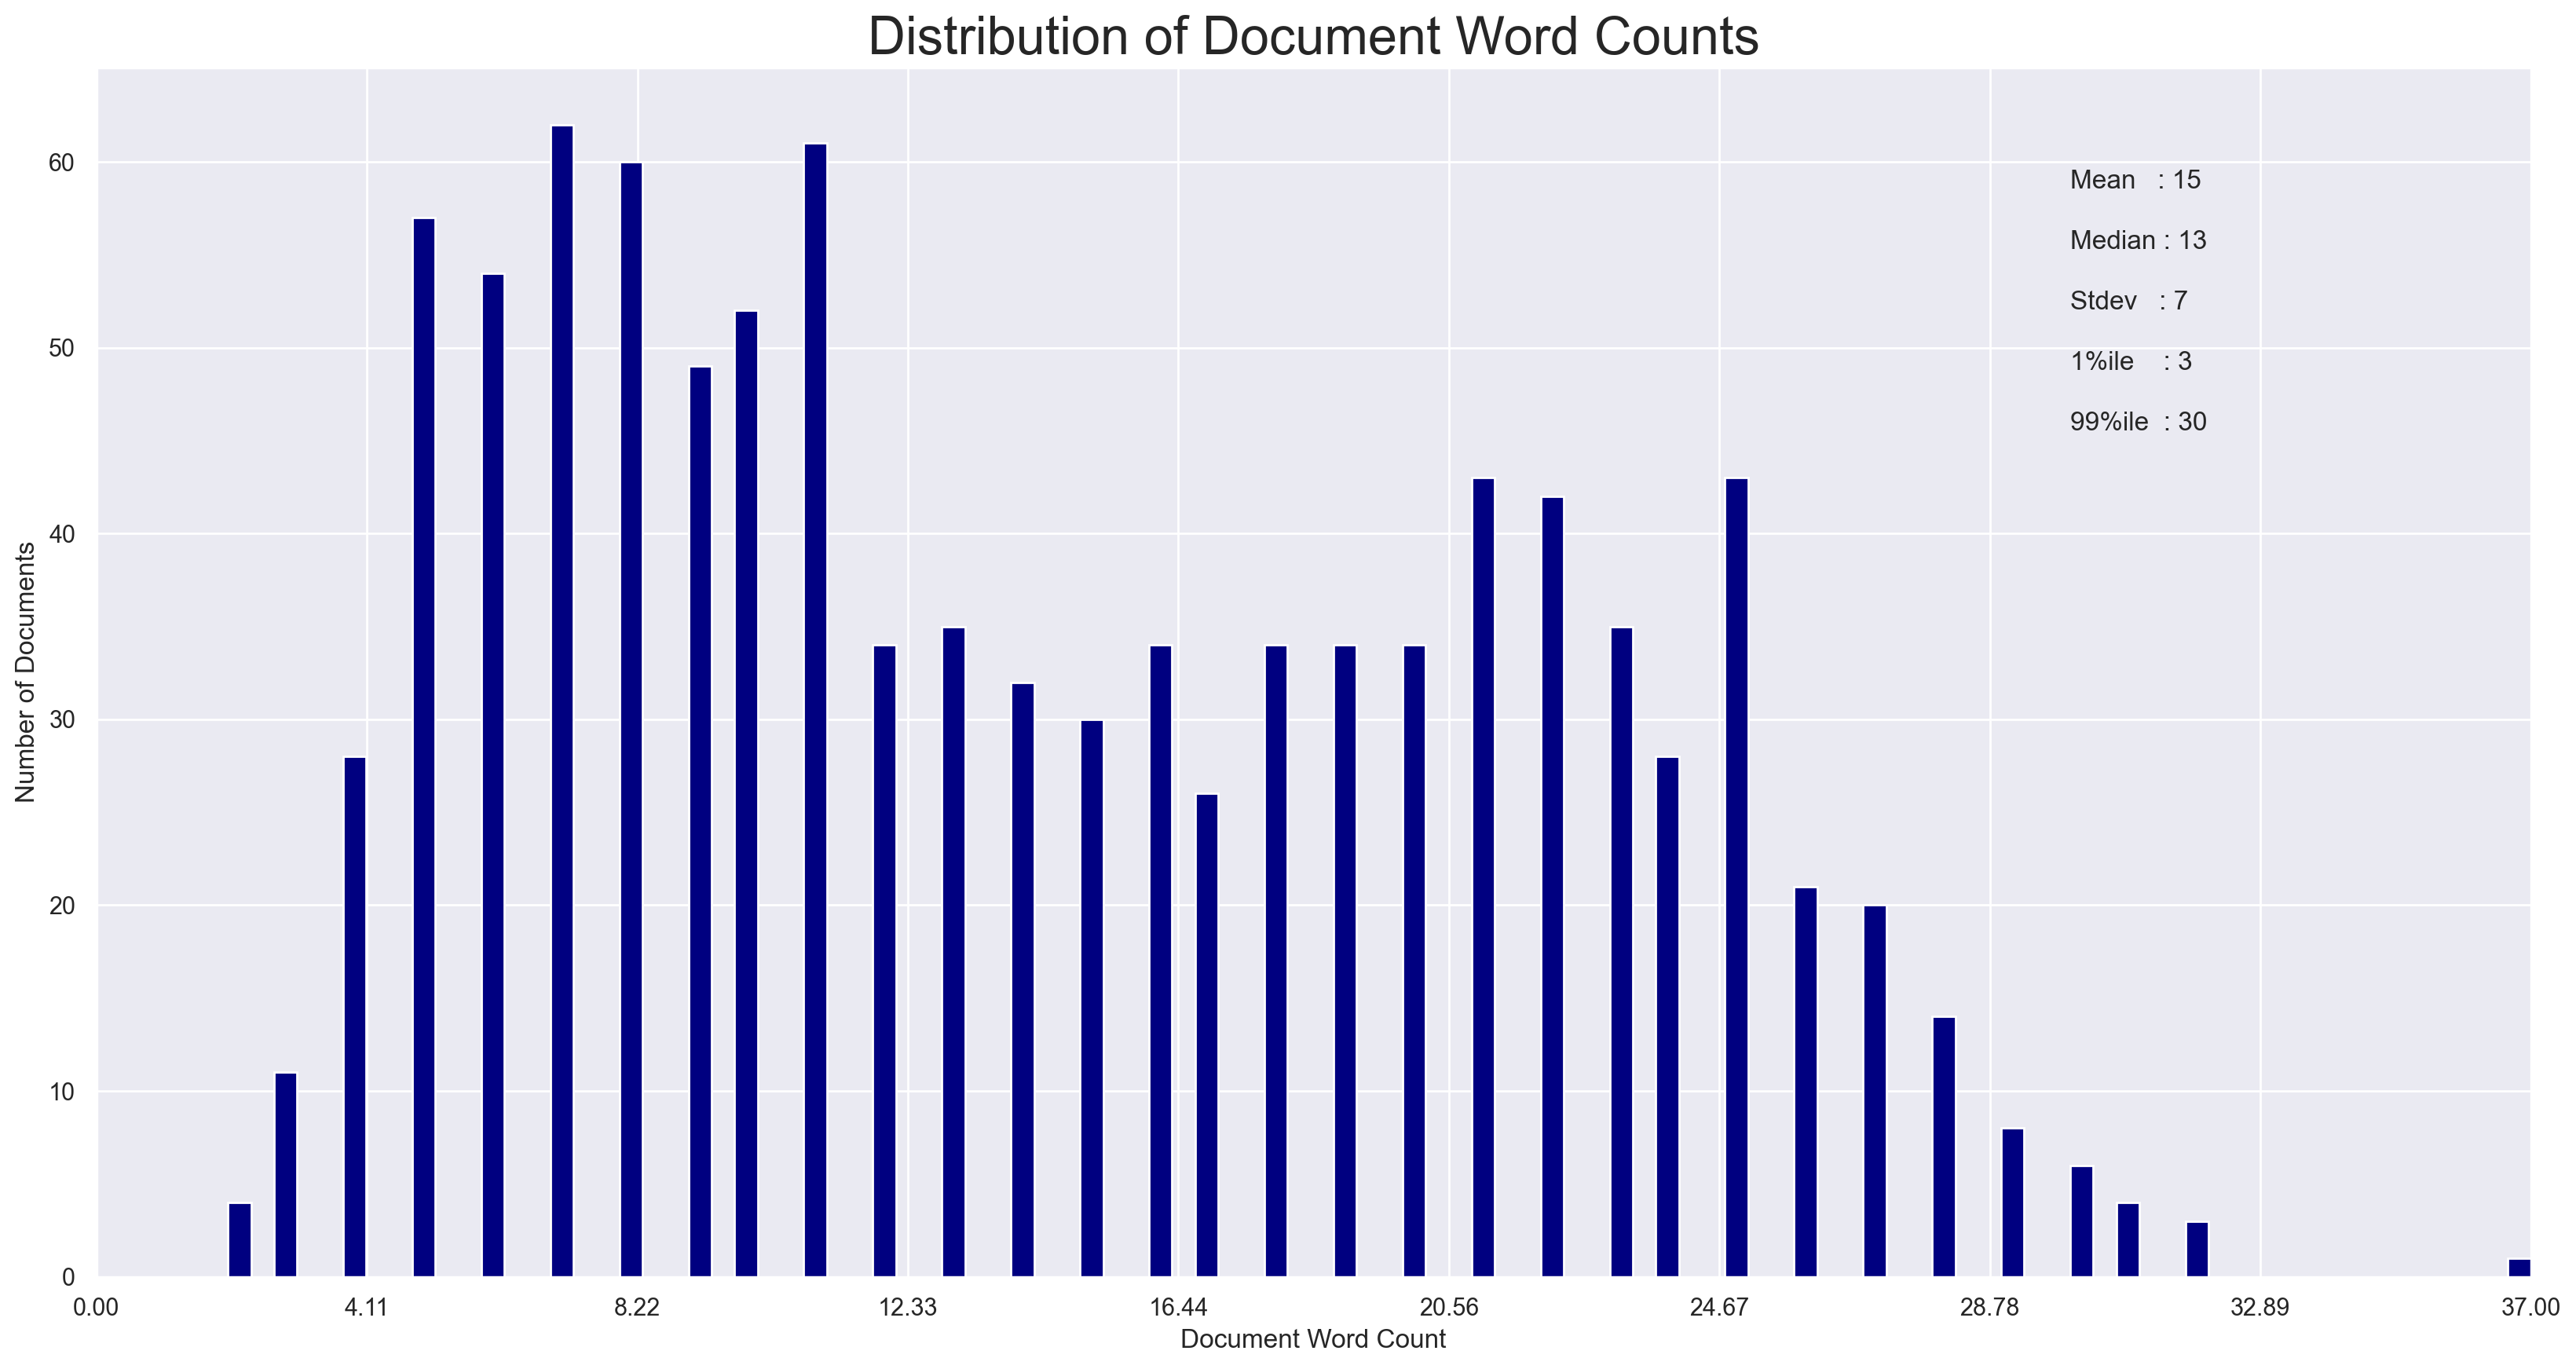

In [61]:
# # Calculate document lengths
# doc_lens = [len(d) for d in df_cleaned['lemmatized_content']]

# # Plot with larger figure size and higher resolution
# plt.figure(figsize=(20, 10), dpi=200)  # Adjust as needed
# plt.hist(doc_lens, bins=100, color='navy')

# # Add statistics as text annotations on the left side of the plot
# plt.text(30, max(plt.gca().get_ylim()) * 0.9, f"Mean   : {round(np.mean(doc_lens))}", fontsize=12)
# plt.text(30, max(plt.gca().get_ylim()) * 0.85, f"Median : {round(np.median(doc_lens))}", fontsize=12)
# plt.text(30, max(plt.gca().get_ylim()) * 0.8, f"Stdev   : {round(np.std(doc_lens))}", fontsize=12)
# plt.text(30, max(plt.gca().get_ylim()) * 0.75, f"1%ile    : {round(np.quantile(doc_lens, q=0.01))}", fontsize=12)
# plt.text(30, max(plt.gca().get_ylim()) * 0.7, f"99%ile  : {round(np.quantile(doc_lens, q=0.99))}", fontsize=12)

# # Configure plot settings
# plt.gca().set(xlim=(0, max(doc_lens)), ylabel='Number of Documents', xlabel='Document Word Count')
# plt.xticks(np.linspace(0, max(doc_lens), 10))
# plt.title('Distribution of Document Word Counts', fontdict={'size': 24})
# plt.show()


# ML model Implementation -LSA Model

In [53]:
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
# from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
# import numpy as np

# Step 1: Prepare text data
# Assuming 'lemmatized_text' is a list of lists of lemmatized tokens as per your previous code
lemmatized_text = [tokens for tokens in df_cleaned['lemmatized_content']]

# Step 2: Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False)
tfidf_matrix = tfidf_vectorizer.fit_transform(lemmatized_text)

# Step 3: Train LSA model using TruncatedSVD
num_topics = 5
lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_matrix = lsa_model.fit_transform(tfidf_matrix)

# Step 4: Extract top words for each topic
def get_lsa_topics(model, vectorizer, n_words=10):
    topics = []
    for idx, topic in enumerate(model.components_):
        top_words_indices = topic.argsort()[:-n_words - 1:-1]
        top_words = [vectorizer.get_feature_names_out()[i] for i in top_words_indices]
        topics.append(top_words)
    return topics

topics = get_lsa_topics(lsa_model, tfidf_vectorizer)

# Step 5: Create a Gensim dictionary and corpus for coherence calculation
dictionary = Dictionary(lemmatized_text)
corpus = [dictionary.doc2bow(text) for text in lemmatized_text]

# Step 6: Calculate the coherence score
coherence_model = CoherenceModel(topics=topics, texts=lemmatized_text, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

# Print coherence score
print(f"Coherence Score: {coherence_score:.4f}")

# Display the topics and their associated words
for i, topic in enumerate(topics):
    print(f"Topic {i}: {', '.join(topic)}")


Coherence Score: 0.4730
Topic 0: phone, love, great, samsung, edge, feature, best, galaxy, camera, screen
Topic 1: samsung, galaxy, best, ever, plus, love, one, edge, always, far
Topic 2: love, easy, samsung, product, use, galaxy, edge, feature, plus, recommend
Topic 3: love, phone, everything, easy, use, perfect, need, get, amazing, time
Topic 4: love, great, awesome, best, ever, camera, everything, picture, feature, take
